In [1]:
import torch
from fastai2.basics           import *
from fastai2.vision.all       import *
from fastai2.medical.imaging  import *
from fastai2.callback.tracker import *
from fastai2.callback.all     import *
torch.cuda.set_device(2)

In [2]:
# from rsnautils import *

nw = 8
pre = 'rn34_repl'

## Pretrain on sample

In [3]:
fns = L(list(df_comb.fname)).map(filename)
fn = fns[0]
fn

NameError: name 'df_comb' is not defined

In [6]:
splits = split_data(df_comb,0)

NameError: name 'split_data' is not defined

In [5]:
def get_data(bs,sz): return get_data_pil(fns, bs, splits=splits, sz=sz, use_hist=False)

In [6]:
dbch = get_data(512, sz=128)
xb,yb = to_cpu(dbch.one_batch())
# dbch.show_batch(max_n=4, figsize=(9,6))
xb.mean(),xb.std(),xb.shape,len(dbch.train_dl)

(tensor(-0.1214), tensor(0.9939), torch.Size([512, 3, 128, 128]), 1053)

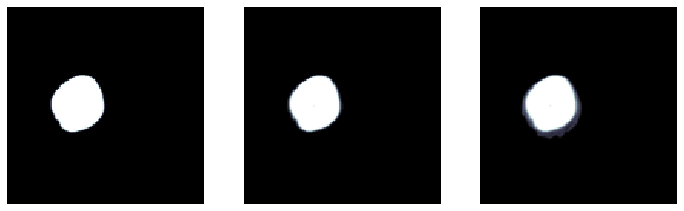

In [7]:
show_images(xb[0])

In [8]:
loss_func = get_loss()

In [9]:
def get_learner(lf=loss_func, fp16=True):
    learn = cnn_learner(dbch, resnet34, pretrained=False, loss_func=lf, opt_func=opt_func, metrics=metrics)
    if fp16: learn = learn.to_fp16()
    return learn

In [10]:
def fit_tune(bs, sz, epochs, lr):
    learn.dbunch = get_data(bs, sz)
    do_fit(learn, epochs, lr, freeze=False)

In [11]:
learn = get_learner()
#TODO same thing for single label clas
learn.model[1][8].bias.data = to_device(logit(avg_lbls))

In [11]:
fit_tune(256, 128, 20, 3e-2)
learn.save(f'{pre}a1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.140949,0.160142,0.951221,0.904317,08:39
1,0.129881,0.129937,0.960162,0.923674,08:57
2,0.128108,0.127426,0.961704,0.922725,09:11
3,0.121263,0.131080,0.957745,0.922717,09:07
4,0.120499,0.121601,0.962020,0.924520,09:10
5,0.117910,0.126844,0.955621,0.883379,09:11
6,0.115781,0.128989,0.958260,0.914860,09:06
7,0.113933,0.113083,0.963737,0.921708,08:47
8,0.111369,0.115241,0.962047,0.918288,08:53
9,0.109899,0.117833,0.963737,0.924194,08:54


In [12]:
fit_tune(512, 224, 10, 6e-3)
learn.save(f'{pre}a2')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.080579,0.086997,0.973294,0.948975,12:47
1,0.079565,0.089957,0.973186,0.949079,12:44
2,0.079729,0.087659,0.973282,0.950942,12:47
3,0.077453,0.084489,0.973992,0.950912,12:39
4,0.075205,0.081697,0.974669,0.950697,12:44
5,0.074030,0.082559,0.973924,0.949220,12:41
6,0.072317,0.081156,0.974223,0.948449,12:32
7,0.068380,0.078621,0.975030,0.950355,12:38
8,0.066935,0.078495,0.975304,0.951773,12:31
9,0.064214,0.078876,0.975550,0.952707,12:27


In [13]:
fit_tune(256, 352, 4, 2e-3)
learn.save(f'{pre}a3')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.078011,0.082457,0.972910,0.946104,33:03
1,0.074408,0.079043,0.975056,0.952285,33:00
2,0.068901,0.075658,0.975830,0.952752,33:09
3,0.063990,0.075248,0.975939,0.952626,33:24


In [17]:
fit_tune(96, 512, 3, 1e-4)
learn.save(f'{pre}a4')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.067253,0.078504,0.975445,0.952715,1:00:25
1,0.067149,0.077360,0.975505,0.952500,1:00:36
2,0.064889,0.076685,0.975693,0.952915,1:00:40


## Prepare for submission

In [12]:
learn.dbunch = get_data(128, 352)
learn.load(f'{pre}a3')

In [13]:
path_tst = path/'tst_jpg'

In [14]:
test_fns = [(path_tst/f'{filename(o)}.jpg').absolute() for o in df_tst.fname.values]
fn = test_fns[0]

In [15]:
tst = test_dl(learn.dbunch, test_fns)
x = tst.one_batch()[0]
x.min(),x.max(),x.mean(),x.std(),x.shape

(tensor(-0.6667, device='cuda:5'),
 tensor(2.6667, device='cuda:5'),
 tensor(-0.1759, device='cuda:5'),
 tensor(0.9536, device='cuda:5'),
 torch.Size([256, 3, 352, 352]))

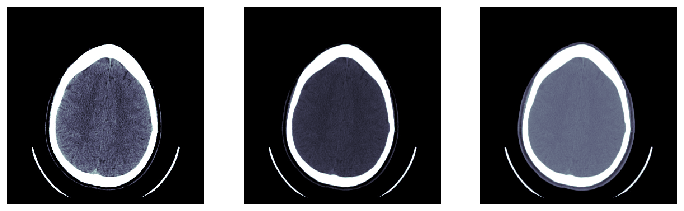

In [16]:
show_images(x[0])

In [17]:
preds,targs = learn.get_preds(dl=tst)

In [56]:
preds_scl = (logit(preds)*0.88).sigmoid()

In [57]:
probs = preds_scl.clamp(1e-4,1-1e-4)

In [58]:
def submission(df_tst, preds):
    ids,labels = [],[]
    for idx,pred in zip(df_tst.index, preds):
        for i,label in enumerate(htypes):
            ids.append(f"{idx}_{label}")
            labels.append('{0:1.10f}'.format(pred[i].item()))
    df_csv = pd.DataFrame({'ID': ids, 'Label': labels})
    return df_csv

In [59]:
pred_csv = submission(df_tst, probs)

In [18]:
prev_csv = pd.read_csv('subm/subm_avg.csv')
pred2_df = pred_csv.merge(prev_csv, on='ID')
pred2_samp = pred2_df.sample(10000)
np.corrcoef(pred2_samp.Label_x.astype(np.float64),pred2_samp.Label_y, rowvar=False)

x,y = tensor(pred2_samp.Label_x.astype(np.float32)),tensor(pred2_samp.Label_y.astype(np.float32))
plt.figure(figsize=(7,7))
plt.scatter(logit(x),logit(y), s=1, alpha=0.3);

In [62]:
nm = 'replace_ashaw_refactor_scl_088'
pred_csv.to_csv(f'subm/{nm}.csv', index=False)

In [54]:
from IPython.display import FileLink, FileLinks
FileLink(f'subm/{nm}.csv')

/home/jhoward/git/rsna_brain/subm/replace_ashaw_refactor.csv

In [64]:
from kaggle import api
api.competition_submit(f'subm/{nm}.csv', '0.0744,rn34_repl (scl 0.88)', 'rsna-intracranial-hemorrhage-detection')

100%|██████████| 16.9M/16.9M [00:00<00:00, 5.78MB/s]


Successfully submitted to RSNA Intracranial Hemorrhage Detection

In [13]:
t = to_cpu(learn.get_preds(act=noop))

In [14]:
preds,targs = t

In [15]:
lw2 = tensor(2.0, 1, 1, 1, 1, 1)
lf2 = BaseLoss(nn.BCEWithLogitsLoss, pos_weight=lw2, floatify=True, flatten=False, 
    is_2d=False, activation=torch.sigmoid)

In [16]:
lf2(preds, targs)

tensor(0.0752)

In [17]:
def f(x): return lf2(preds*x,targs)

In [18]:
scipy.optimize.minimize_scalar(f, bounds=(0.2,2), method='Bounded', options={'xatol':0.001})

     fun: tensor(0.0744)
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: tensor(0.8820)

In [19]:
pre

'rn34_repl'